# XGBoost - Baseline
## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Dataloading

In [2]:
import json

categorical_df = pd.read_excel("./data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_df = pd.read_excel("./data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
solutions_df = pd.read_excel("./data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

# load categorical labels
with open("categorical_labels.json", "r") as file:
    categorical_labels = json.load(file)

# json cant store keys of type int, cast int keys back to int
categorical_labels = {category: {int(key): label for key, label in mapping.items()} for category, mapping in categorical_labels.items()}

## Data Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import StandardScaler

df = pd.merge(categorical_df, quantitative_df, on="participant_id", how="inner")
df = pd.merge(df, solutions_df, on="participant_id", how="inner")

X = df.drop(columns=["participant_id", "ADHD_Outcome", "Sex_F"])
y = df["ADHD_Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

## Class Balancing

In [4]:
from collections import Counter

# Inspect training class distribution
counter = Counter(y_train)
print("Training class distribution:", counter)

# Compute the balance ratio.
# For binary classification (e.g., classes 0 and 1), a common approach is:
#   scale_pos_weight = (number of negatives) / (number of positives)
# This is particularly useful if the positive class is the minority.
scale_pos_weight = counter[0] / counter[1]
print("Computed scale_pos_weight:", scale_pos_weight)

Training class distribution: Counter({1: 665, 0: 305})
Computed scale_pos_weight: 0.45864661654135336


## Hyperparameter Tuning

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define a baseline XGBoost model with class balancing.
base_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # adjust for class imbalance
    random_state=42,            # suppresses warning for new versions
    eval_metric='logloss'               # define evaluation metric explicitly
)

# Define a grid of hyperparameters to search.
param_grid = {
    'n_estimators': [87, 88, 89],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.04, 0.05, 0.06],
    'subsample': [0.73, 0.74, 0.75],
    'colsample_bytree': [0.48, 0.49, 0.5],
    'gamma': [0.42, 0.43, 0.44]
}

# Set up GridSearchCV using ROC-AUC as the evaluation metric.
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit grid search on the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model found during grid search
best_model = grid_search.best_estimator_
print("Best hyperparameters found:", grid_search.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.48, gamma=0.42, learning_rate=0.04, max_depth=1, n_estimators=87, subsample=0.73; total time=   0.0s
[CV] END colsample_bytree=0.48, gamma=0.42, learning_rate=0.04, max_depth=1, n_estimators=87, subsample=0.73; total time=   0.0s
[CV] END colsample_bytree=0.48, gamma=0.42, learning_rate=0.04, max_depth=1, n_estimators=87, subsample=0.74; total time=   0.0s
[CV] END colsample_bytree=0.48, gamma=0.42, learning_rate=0.04, max_depth=1, n_estimators=87, subsample=0.74; total time=   0.0s
[CV] END colsample_bytree=0.48, gamma=0.42, learning_rate=0.04, max_depth=1, n_estimators=87, subsample=0.74; total time=   0.1s[CV] END colsample_bytree=0.48, gamma=0.42, learning_rate=0.04, max_depth=1, n_estimators=87, subsample=0.74; total time=   0.0s

[CV] END colsample_bytree=0.48, gamma=0.42, learning_rate=0.04, max_depth=1, n_estimators=87, subsample=0.75; total time=   0.0s
[CV] END colsample_bytree=0.48, g

## Training

In [6]:
# Make predictions on test data using the best model
y_pred = best_model.predict(X_test)

## Evaluation

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.644     0.727     0.683        77
           1      0.865     0.813     0.839       166

    accuracy                          0.786       243
   macro avg      0.755     0.770     0.761       243
weighted avg      0.795     0.786     0.789       243



ROC-AUC Score: 0.7702628696604601


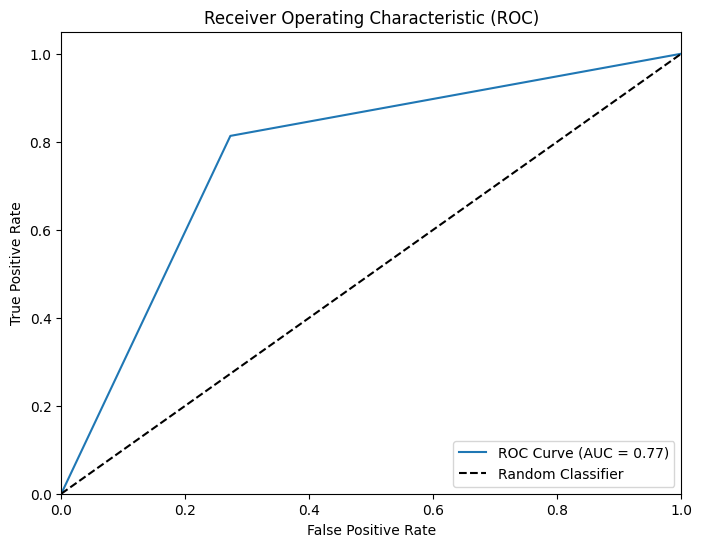

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

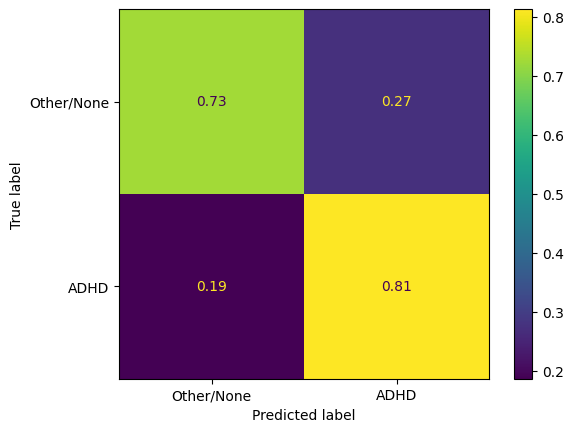

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', display_labels=categorical_labels['ADHD_Outcome'].values())
plt.show()

/tmp/ipykernel_7004/2534711162.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(feature_importance_df, x='Importance', y='Feature', palette='crest')


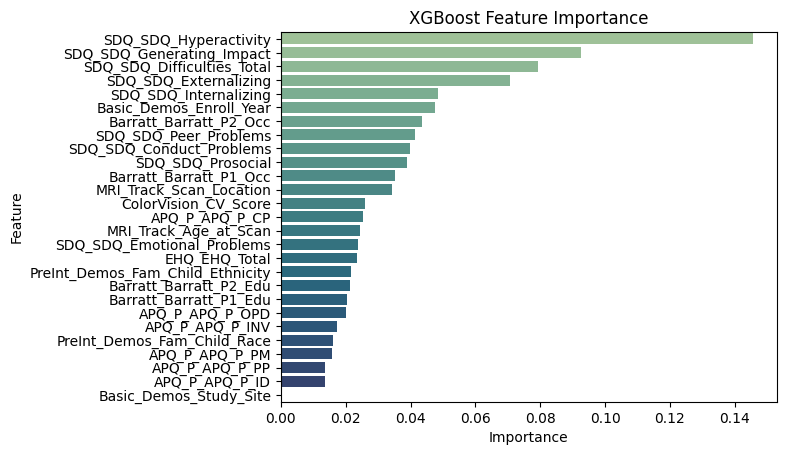

In [10]:
feature_importance_df = pd.DataFrame({
    'Importance': best_model.feature_importances_,
    'Feature': X.columns
}).sort_values(by='Importance', ascending=False)

plt.title('XGBoost Feature Importance')
sns.barplot(feature_importance_df, x='Importance', y='Feature', palette='crest')
plt.show()